# Multi-label CLassification of Toxic Comments Dataset <a class="jp-toc-ignore"></a>

# Introduction

The objective of this notebook is to build and asses an NPL model preforming mult-label classification on toxic comments dataset from [Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

**Data**

The dataset contains of 4 csv files of witch train.csv was concatenated with merged test.csv and test_labels.csv (the rows with values -1 were dropped as specified in the description on kaggle). This way prepared dataset named data.csv was loaded into sessions disk space.

**Cleaning**

The data has been check for duplicates and missing vlaues
The data was cleaned using regex modul to contain only small and big letters of English alphabet, punctuations ('.!?) and new lines. New lines has been replaced with space. Symbols which has been consecutivelly appearing in words with frequency more than 2 has been removed.

**EDA**

The check of the length of comment and overal distribution.
Distribution of labels.
Comparison of lengths for containing or not containing a label.

**Modeling**

For modeling purposes the data was split into 3 parts with multilabel stratified split and stored on personal drive to avoid loading data to the runtime disk.

Modeling was performed on two models from transformers library (Distilbert and Roberta) with the use of n_labels parameter. This way on top of the backbone of models additional layers were added which were not trained but initialized by the library.

The other solution would be to get the sequence of children from the model architecture and add nn.Linear() and sigmoid function.

The loss function is a **Binarry Cross Entropy With Logits Loss** which take an argument for unbalanced classes (pos_weight in a form of tensor) and uses sigmoid function. This is more numerically stable than deducing probability seperately.

The training was performed for one epoch on the layers that were initialized for the given architecture with lr=1e-3 and then ten finetuned for up to 20 epochs with lr=1e-5, early stopping and saving best two models.

One epoch took batch size 16 and max length of tokens in a sequence equal to 512(default for those models).

To avoid the runtime crushing the parameter for accumulating gradient for two epochs was used.

**Evaluating**

The threshold for the classification was set with the use of validation set (minimazing the time of exection) based on the weighted **f1-score**. We aimed for highiest precision and recall at the same time.

The evaluation of metrics was done on the training set.

Two predictions with highiest mse score were displayed to showcase the intuition behind being wrong.


# Environment preparation and helper functions

In [1]:
!pip install -q scikit-multilearn iterative-stratification torch pytorch-lightning transformers[torch] accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.9 MB/s eta 0:00:00


In [2]:
# Global variables
RANDOM_SEED = 42
URL = "/content/drive/MyDrive/Colab/toxic_data/"
TRAIN_EPOCHS = 1
FINETUNE_EPOCHS = 20
TRAIN_LR = 1e-3
FINETUNE_LR = 1e-5

In [3]:
# Libraries
from google.colab import files, drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import re
import os
import time
import multiprocessing
from tqdm.auto import tqdm
from itertools import chain
import ast
from typing import List, Tuple, Any, Dict, Union
from sklearn.metrics import (roc_auc_score,
                             classification_report,
                             roc_curve, auc, f1_score,
                             mean_squared_error,
                             multilabel_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from sklearn.model_selection import train_test_split
from itertools import chain
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
from pytorch_lightning.loggers import TensorBoardLogger

from transformers import (RobertaForSequenceClassification,
                          DistilBertForSequenceClassification,
                          DistilBertModel,
                          RobertaConfig, DistilBertConfig,
                          RobertaTokenizer,
                          DistilBertTokenizer, BertTokenizerFast as BertTokenizer, BertModel, AdamW )

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [4]:
# ************************* Cleaning data *************************

def cleaned_string(text: str) -> str:
    """
    Gets the letters and ('\n!?.) from the string,
    replaces new lines with space,
    removes more than two consecutive characters
    and cleans from https.

    Args:
        text (str): string to be modified
    Returns:
        leaned_string (str): modified string.
    """
    # Getting letters and symbols
    new_string = re.sub("[^A-Za-z '\n!?.]+", '', text)
    # Replacing new line with space
    replaced_string = new_string.replace("\n", " ").strip()
    # Removing consecutive duplicates
    cleaned_string = re.sub(r'([a-zA-Z])\1+', r'\1\1', replaced_string)
    # Remove http
    leaned_string = re.sub(r'\bhttp\S*\b', '', cleaned_string)
    return leaned_string

def word_count(text: str) -> int:
    """
    Counts number of words in a string.

    Args:
        text (str): string to be counted
    Returns:
        count (int): count of words
    """
    count = len(text.split())
    return count

# ************************* Splitting data *************************

def encode_label(df: pd.DataFrame,
                 target_list: List[str]) -> pd.DataFrame:
    """
    Encodes label columns in the DataFrame and creates new column.

    Args:
        df (pd.DataFrame): input DataFrame
        target_list (List[str]): list of target labels
    Returns:
        pd.DataFrame: DataFrame with encoded label column
    """
    df['label'] = df[target_list].values.tolist()
    df['label'] = df['label'].apply(lambda x: [float(ele) for ele in x])
    return df

# The source of the following function is given at the end of the notebook
def multilabel_train_test_split(*arrays: Any,
                                test_size: float = None,
                                train_size: float = None,
                                random_state: int = 123,
                                shuffle: bool = True,
                                stratify: List = None) -> Tuple:
    """
    Train test split for multilabel classification. Uses the algorithm from:
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011)
    On the Stratification of Multi-Label Data'.

    Args:
        *arrays (Any): any number of arrays to be splitted
        test_size (float): fration of test split
        train_size (float): fraction of data for train set
        random_state (int): random seed
        shuffle (bool): whether to shuffle data before split
        stratify (List): list representing stratification

    Returns:
        Tuple: a tuple of split arrays
    """

    if stratify is None:
        return train_test_split(*arrays,
                                test_size=test_size,
                                train_size=train_size,
                                random_state=random_state,
                                stratify=None, shuffle=shuffle)

    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"

    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test,
                                          train_size=n_train,
                                          random_state=random_state)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

# ************************ Modeling *************************

def training(model: pl.LightningModule,
             logger: pl.loggers,
             callbacks: List[pl.Callback],
             train_epochs: int = TRAIN_EPOCHS,
             finetune_epochs: int = FINETUNE_EPOCHS,
             train_lr: float = TRAIN_LR,
             finetune_lr: float = FINETUNE_LR) -> None:
    """
    Trains and fine-tunes the model.

    Args:
        model (pl.LightningModule): PyTorch Lightning model
        logger (pl.loggers.base.LightningLoggerBase): logger for tracking training
        callbacks (List[pl.Callback]): list of PyTorch Lightning callbacks
        train_epochs (int): number of epochs for the initial training
        finetune_epochs (int): number of epochs for the fine-tuning
        train_lr (float): learning rate for the initial training
        finetune_lr (float): learning rate for the fine-tuning

    Returns:
        None
    """
    start = time.time()
    print("*"*25, "Training", "*"*25)

    # Initial Training
    trainer = pl.Trainer(max_epochs=train_epochs,
                         accumulate_grad_batches=2)
    trainer.fit(model)

    print("*"*25, "Training", "*"*25)

    # Fine-tuning
    model.base_grad(True)
    model.lr = finetune_lr
    fine_trainer = pl.Trainer(logger=logger,
                              callbacks=callbacks,
                              max_epochs=finetune_epochs,
                              accumulate_grad_batches=2)
    fine_trainer.fit(model)

    end = time.time()
    execution_time = end - start
    print(f"Execution time: {round(execution_time/3600, 1)} hours.")


# ************************* Making predictions *************************

def model_preds(model: pl.LightningModule, loader: DataLoader) -> Tuple:
    """
    Generates predictions from a PyTorch Lightning model.

    Args:
        model (pl.LightningModule): the module
        loader (DataLoader): DataLoader for the input data

    Returns:
        Tuple: tuple containing predictions, true labels,
        losses, and input_ids_list.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.eval().to(device)
    predictions = []
    y_true = []
    losses = []
    input_ids_list = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            input_ids_list.append(batch['input_ids'].tolist())
            outputs, loss = model(**batch)
            batch_predictions = outputs.tolist()
            predictions += batch_predictions
            y_true += batch['labels'].int().tolist()
            losses.append(loss.item())

    return np.array(predictions), np.array(y_true), losses, input_ids_list

# ************************* Evaluating *************************

def threshold_estimation(predictions: np.ndarray,
                         y_true: np.ndarray,
                         target_list: List[str]) -> List[float]:
    """
    Estimates the best threshold for each label using weighted F1 score
    for multi-label classification.

    Args:
        predictions (np.ndarray): model predictions in a probability form
        y_true (np.ndarray): true labels
        target_list (List[str]): list of target labels

    Returns:
        List[float]: List of best thresholds for each label.
    """

    thresholds = np.arange(0.05, 0.95, 0.05)
    best_thresholds = []

    for i, name in enumerate(target_list):
        f1_scores = [f1_score(y_true[:, i],
                     (predictions[:, i] > t).astype(int), average='weighted')
                     for t in thresholds]
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)
        print(f"{name}: {round(best_threshold, 2)}")

    return best_thresholds


def calculate_predictions(predictions: np.ndarray,
                          threshold: float) -> np.ndarray:
    """
    Calculate binary predictions based on a given threshold.

    Args:
        predictions (np.ndarray): model predictions as probabilities
        threshold (float): threshold for binary classification

    Returns:
        np.ndarray: binary predictions
    """
    return (predictions > threshold).astype(int)


def metric_display(predictions: np.ndarray,
                   y_true: np.ndarray,
                   target_list: List[str],
                   threshold: float) -> None:
    """
    Display evaluation metrics including ROC-AUC scores,
    ROC curves and classification report for each label.

    Args:
        predictions (np.ndarray): model predictions as logits
        y_true (np.ndarray): true binary labels
        target_list (List[str]): list of target labels
        threshold (float): threshold for binary classification
    Returns:
        None
    """

    # Calculate predictions for given threshold
    y_pred = calculate_predictions(predictions, threshold)

    # Prints roc_auc for each label
    print("*"*25, "ROC_AUC per label", "*"*25)
    for i, name in enumerate(target_list):
        tag_roc_auc = roc_auc_score(y_true[:, i], predictions[:, i])
        print(f"{name}: {round(tag_roc_auc, 2)}")

    # Displays roc_curve for each label
    print()
    plt.figure(figsize=(8, 8))
    for i, name in enumerate(target_list):
            fpr, tpr, _ = roc_curve(y_true[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend()
    plt.show()

    # Prints classification report for given threshold
    print("\n", "*"*25, "Classification report", "*"*25)
    print(classification_report(y_true, y_pred,
                                target_names=target_list, zero_division=1.0))

    # Display confusion metrix for each label
    print("\n", "*"*25, f"Normalized Confusion Matrices for Each Label", "*"*25)
    fig, ax = plt.subplots(1, 6, figsize=(16, 2))
    plt.subplots_adjust(wspace=0.5)


    fig.text(0.5, -0.01, 'Predicted Label', ha='center', va='center', fontsize=8)

    for i, name in enumerate(target_list):
        cm = multilabel_confusion_matrix(y_true, y_pred)[i]
        # Normalize the confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=[0, 1], yticklabels=[0, 1],  ax=ax[i], cbar=False)
        ax[i].set_title(name)
        if i == 0:
            ax[i].set_ylabel('True label', fontsize=8)
    plt.show()


# Data

The initial preparation of the data was done locally with the following code:
```py
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
lables = pd.read_csv("test_labels.csv")
# Merging test and labels
df = pd.merge(test, labels, on='id')
# Removing labels with -1
df = df[(df != -1).all(axis=1)]
# Contatenation of train and test and dropping duplicates
comments = (pd.concat([train, df])
            .drop_duplicates(subset='comment_text', keep='first'))
# Saving data
comments.to_csv("data/data.csv", index=False)
```
* Initial test.csv shape: (153164, 2)
* Initial test_lables.csv shape: (153164, 7)
* Shape of merged test with removed -1: (63978, 8)
* Initial train.csv shape: (159571, 8)
* Final data.csv shape: (223549, 8)

Performing this concatenation we gained additional 30% where size of the data reduces overfitting of the model.

In [ ]:
# Upload of data to the runtime
files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv("/content/data.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [ ]:
target_list = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

## Cleaning data

* checking for duplicates and missing values
* making sure the labels are either 0 or 1
* cleaning strings to sentence form
* removing data with less then 2 words

In [ ]:
# Checking for duplicates
assert df[df.duplicated()].size == 0, "Dataframe has duplicates"

# Making sure the target columns have only values 0 or 1
assert df.loc[df[target_list].isin([0, 1]).sum(axis=1) != 6].size == 0, "The target columns are not binary"

# Checking for missing values
assert df.isnull().sum().sum() == 0, "There are missing values in the dataset"

In [ ]:
# Cleaning the string
df['cleaned_comment'] = df['comment_text'].map(cleaned_string)
df['word_count'] = df["cleaned_comment"].map(word_count)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment,word_count
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now,43
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,D'aww! He matches this background colour I'm seemingly stuck with Thanks talk January UTC,14
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,Hey man I'm really not trying to edit war It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,More I can't make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up It's listed in the relevant form eg WikipediaGoodarticlenominationsTransport,109
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,You sir are my hero Any chance you remember what page that's on?,13


After inspecting comments which had one word only with a code
```py
set(df['cleaned_comment'].loc[df['word_count'].isin([0, 1])].to_list())
```
we got an output of 286 unique values of little importance like month, website link, words without any meaning.
We can remove those values.

In [ ]:
# Removing words with
df = df.loc[df['word_count'] > 1]
df.shape

(222702, 10)

There are 222,702 comments after cleaning.

Now lets check the balance of target variables.

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904,0.991,0.946,0.997,0.949,0.990
1,0.096,0.009,0.054,0.003,0.051,0.010


<Figure size 1200x1000 with 0 Axes>

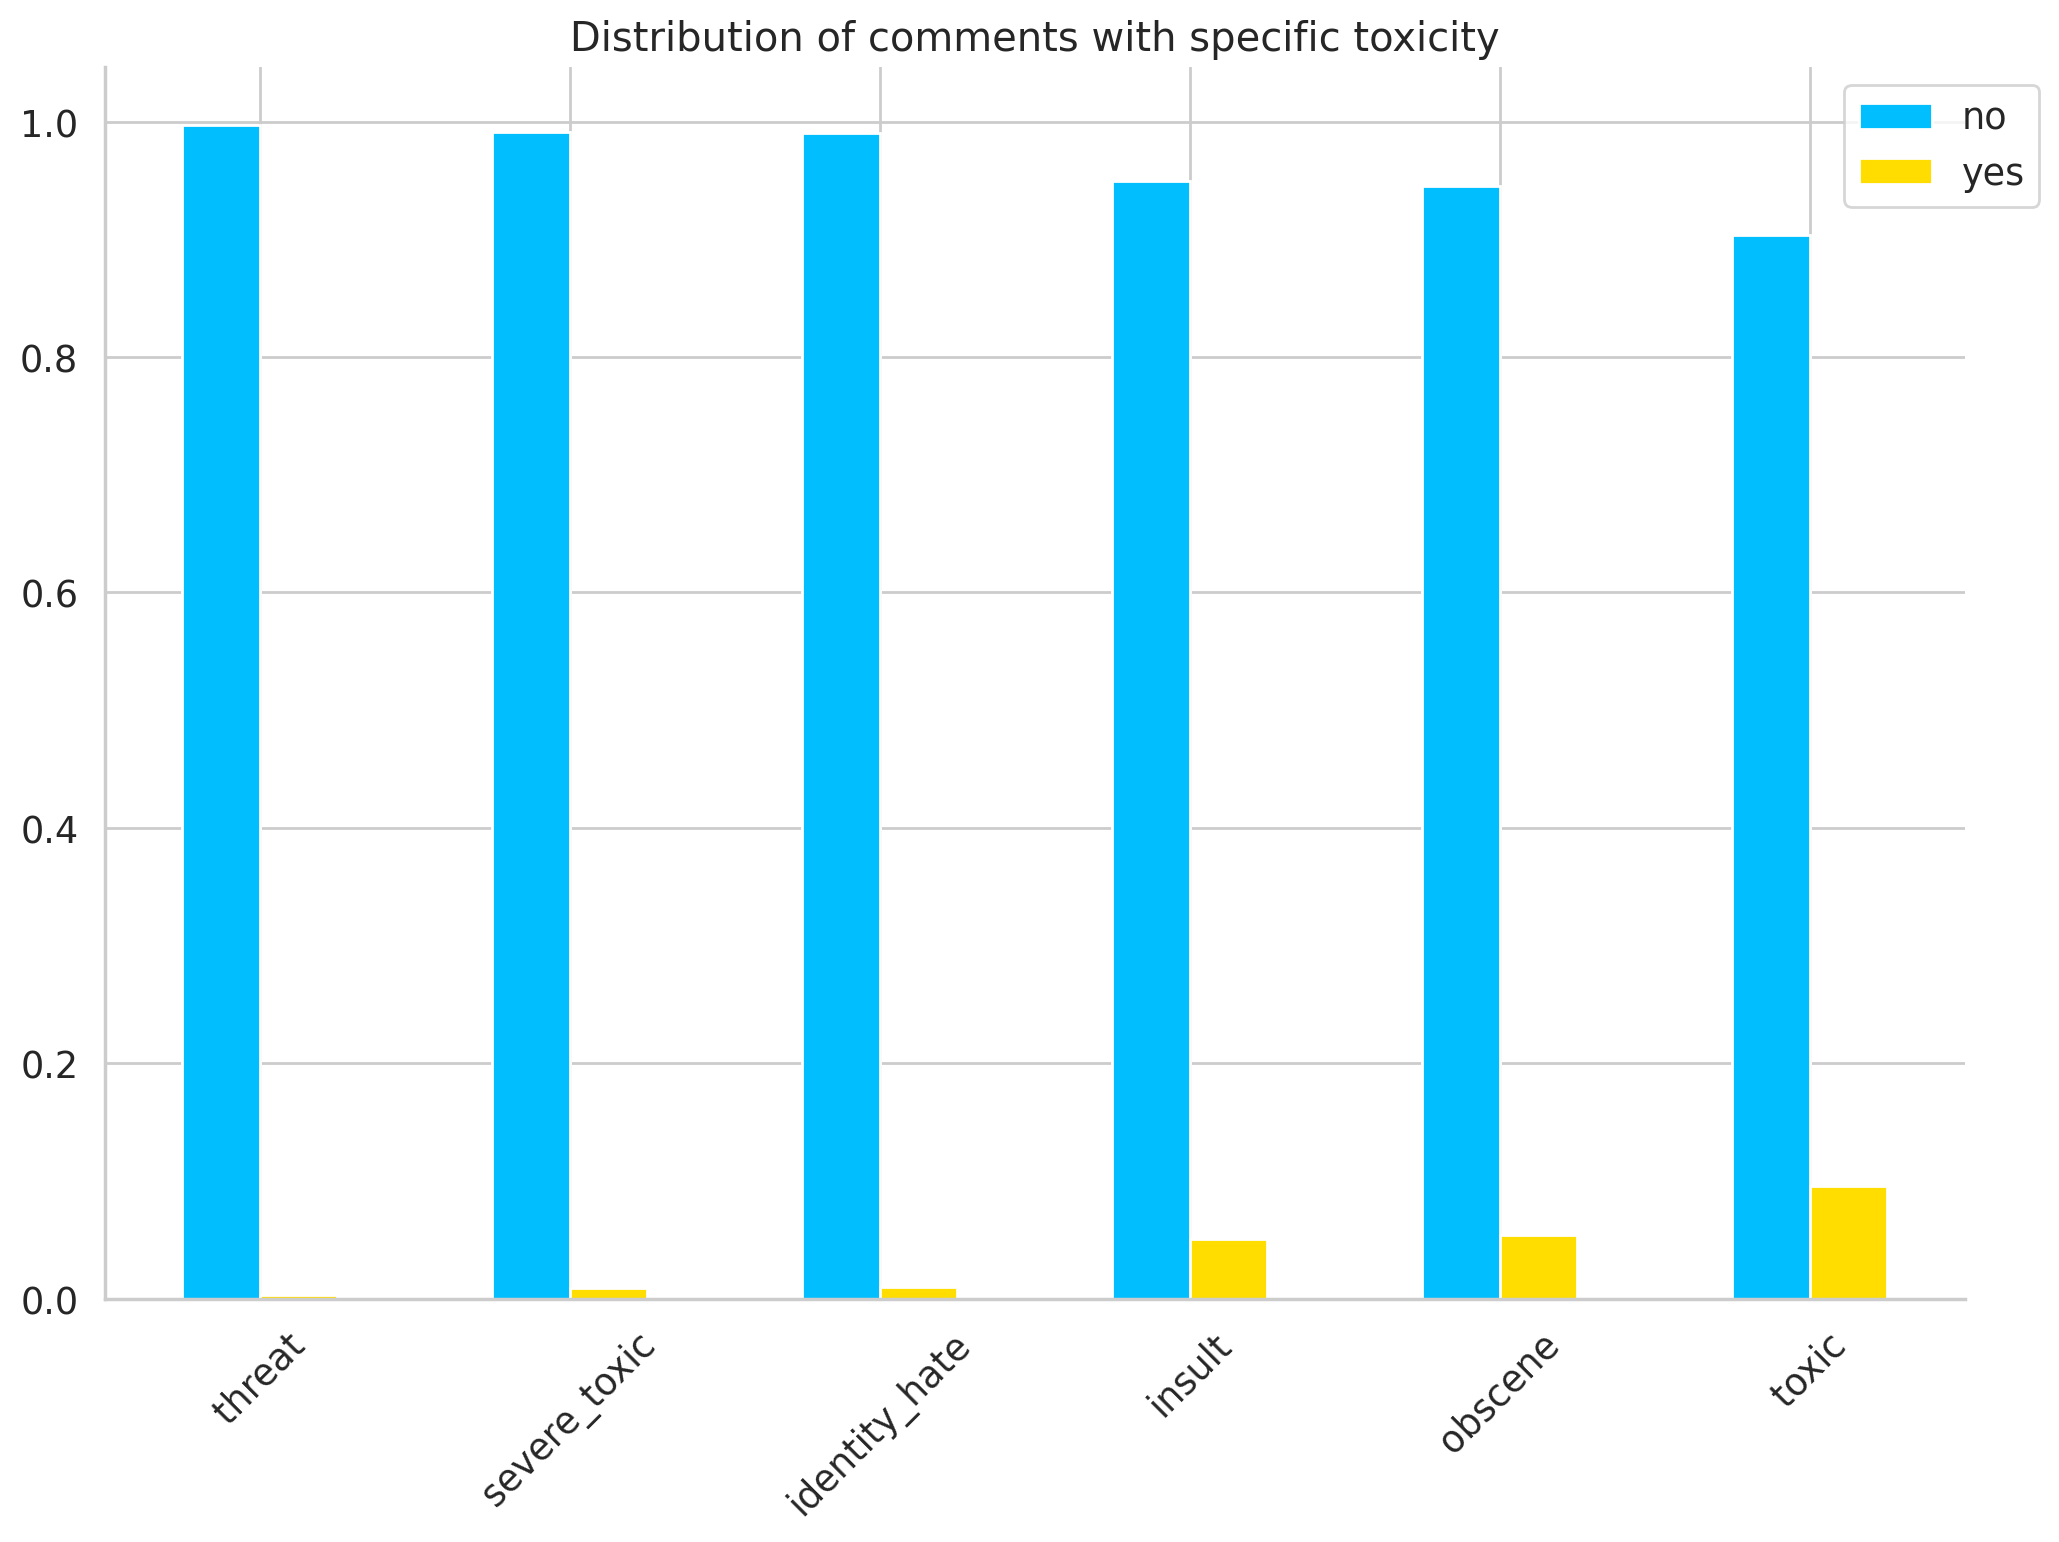

In [ ]:
# Creating dataframe with labels balances
data_balance = df[target_list].apply(pd.value_counts).apply(lambda x: x/sum(x), axis=0)

# Displaying and plotting normalized dataframe
display(data_balance)
data_balance.T.rename(columns={0:"no", 1:"yes"}).sort_values(by='no', ascending=False).plot.bar(rot=45)
plt.title("Distribution of comments with specific toxicity")
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine();

The data is highly imbalanced with some of the class representing only 0.3% of all samples.

Toxic comments are the most popular while comments labeled as threat are the least.

To deal with imbalance we will use:
* stratified sampling
* transfer learning
* pos_weights parameter from Binary Cross Entropy With Logit Loss

Let's see the distribution of length of the comments.

,count,mean,std,min,25%,50%,75%,max
word_count,222702.000,64.480,96.849,2.000,15.000,34.000,72.000,2142.000


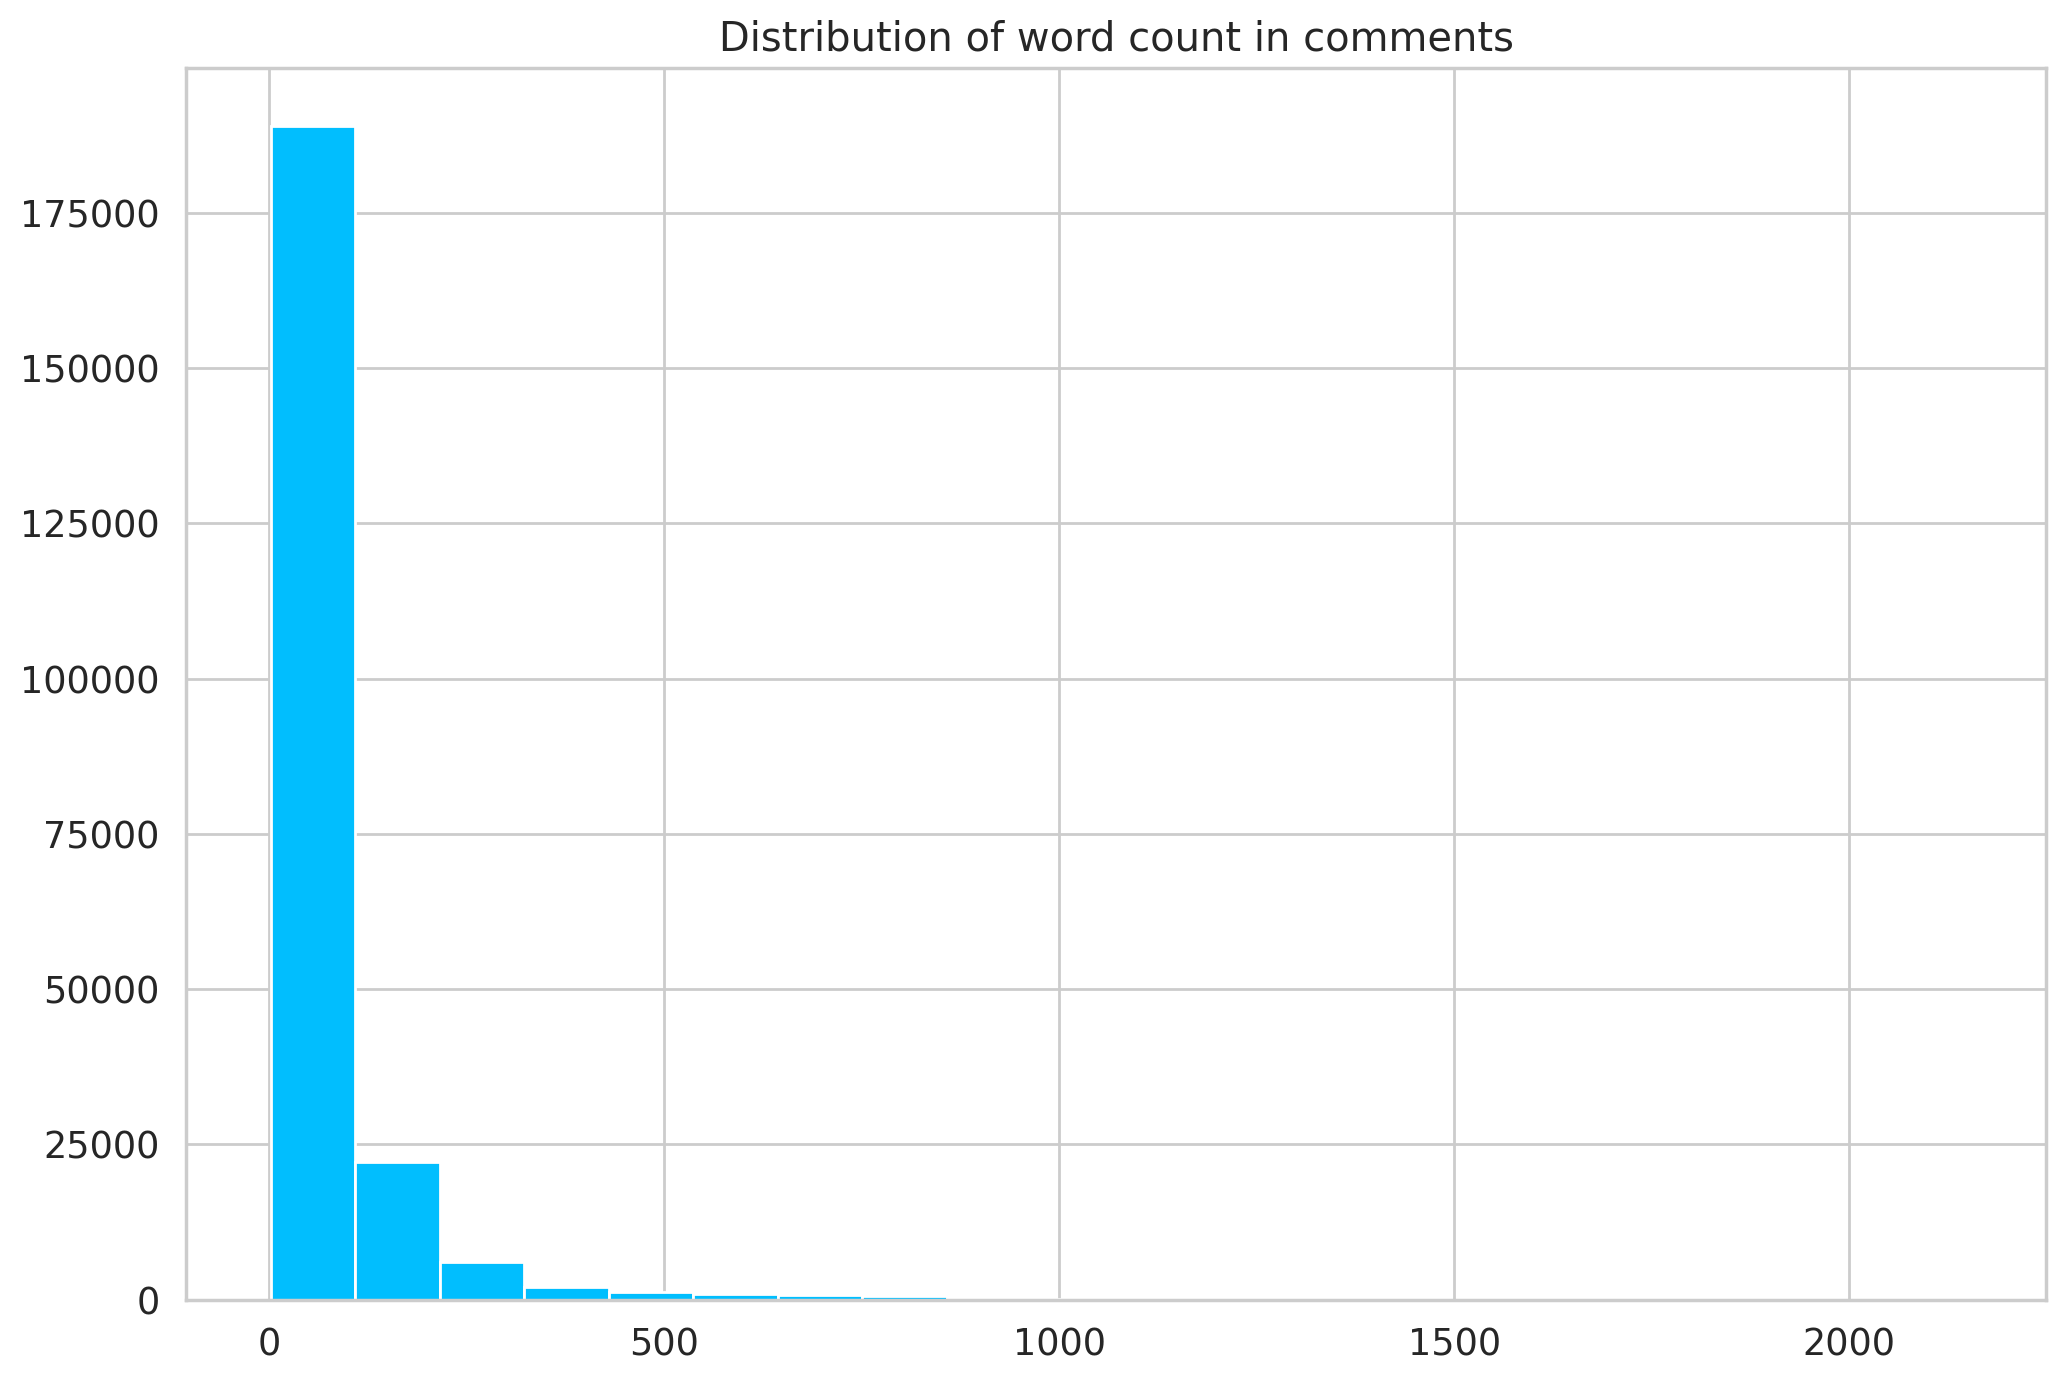

In [ ]:
display(df['word_count'].describe().to_frame().T)
print()
df['word_count'].hist(bins=20)
plt.title("Distribution of word count in comments");

On average there is 64 words in a comment. The maximum value of words reaches more than 2 thousand. To minimize the time spent on training we could choose a lower number of max length of tokens for training ex.128 which most likely would pick up on the label. In this exercise we will go with the default value of 512.

Let's check the number of words used in toxic and non-toxic comments. For visibility the subset of up to 100 words is used.

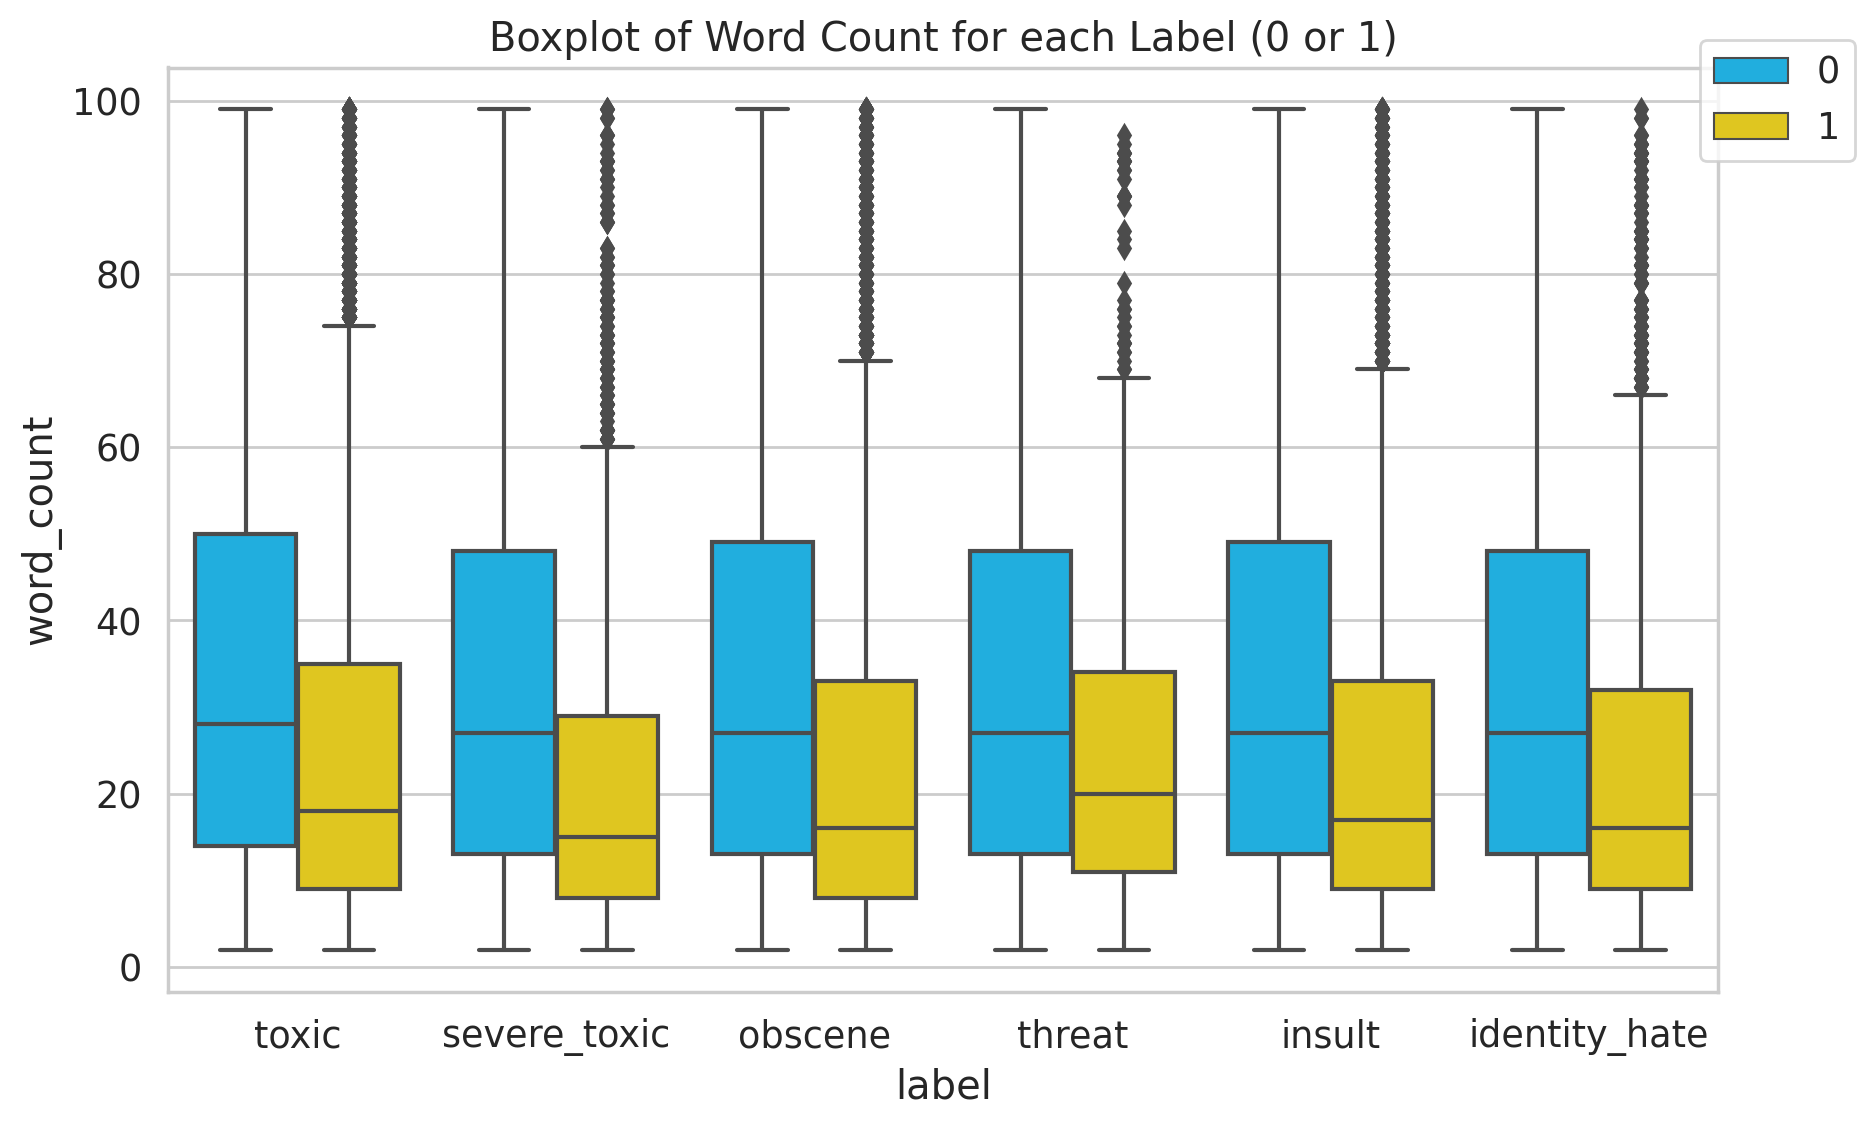

In [ ]:
df_melted = pd.melt(df.loc[df['word_count']<100], id_vars='word_count', value_vars=target_list, var_name='label')

# Create a boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', hue='value', data=df_melted)
plt.legend(bbox_to_anchor=(1.10, 1.05))
plt.title('Boxplot of Word Count for each Label (0 or 1)')
plt.show()

It seems that the word count for undesirable comments has lower mean vlaue of used words with high number of outliers.

## Splitting data

In [ ]:
X = df[["cleaned_comment"]]
y = df[target_list]
X_train, X_temp, y_train, y_temp = multilabel_train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = multilabel_train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_val = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [ ]:
# Sanity check of balanced split
print("Train set distribution", df_train.shape)
display(df_train[target_list].apply(pd.value_counts).apply(lambda x: x/sum(x), axis=0))
print("\nValidation set distribution", df_val.shape)
display(df_val[target_list].apply(pd.value_counts).apply(lambda x: x/sum(x), axis=0))
print("\nTest set distribution", df_test.shape)
display(df_test[target_list].apply(pd.value_counts).apply(lambda x: x/sum(x), axis=0))

Train set distribution (178161, 7)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904,0.991,0.945,0.997,0.949,0.990
1,0.096,0.009,0.055,0.003,0.051,0.010



Validation set distribution (22270, 7)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904,0.991,0.946,0.997,0.949,0.991
1,0.096,0.009,0.054,0.003,0.051,0.009



Test set distribution (22271, 7)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904,0.991,0.945,0.997,0.949,0.990
1,0.096,0.009,0.055,0.003,0.051,0.010


We have train set with 178k comments and test and validation set with around 22k samples.

In [ ]:
# # Storing data in personal drive memory
# encode_label(df_train).to_csv(URL+"train.csv", index=False)
# encode_label(df_val).to_csv(URL+"valid.csv", index=False)
# encode_label(df_test).to_csv(URL+"test.csv", index=False)

In [5]:
# Reading in the data
df_train = pd.read_csv(URL + "train.csv")
df_valid = pd.read_csv(URL + "valid.csv")
df_test = pd.read_csv(URL + "test.csv")

## Defining global variables and creating classes

* Dataset
* Pytorch Lightning Module
* Callback

### Variables

In [6]:
target_list = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
NUM_CLASSES = len(target_list)
MAX_SEQUENCE_LENGTH = 512
BATCH_SIZE = 16
POS_WEIGHTS = (torch.FloatTensor(df_train[target_list].apply(pd.value_counts)
                .apply(lambda x: x[0]/x[1], axis=0)))
NUM_WORKERS = multiprocessing.cpu_count()
TRAIN_EPOCHS = 1
FINETUNE_EPOCHS = 20
TRAIN_LR = 1e-3
FINETUNE_LR = 1e-5
PARAMS_TO_TRAIN_DISTILBERT = ['pre_classifier.weight',
                              'classifier.weight',
                              'classifier.bias',
                              'pre_classifier.bias']
PARAMS_TO_TRAIN_ROBERTA = ['classifier.dense.weight',
                           'classifier.out_proj.bias',
                           'classifier.dense.bias',
                           'classifier.out_proj.weight']

### Dataset

In [7]:
class ToxicDataset(Dataset):
    """
    Dataset class for toxic comment classification.

    Parameters:
        df (pd.DataFrame): DataFrame containing cleaned comment and target labels
        arch (str): name of model architecture
        max_sequence_length (int): maximum sequence length for tokenization
        target_list (List): list of target labels

    Returns:
        Dict: encoded input and labels
    """

    archs = {
        "distilbert": (DistilBertTokenizer, "distilbert-base-uncased"),
        "roberta": (RobertaTokenizer, "roberta-base"),
    }

    def __init__(self, df: pd.DataFrame,
                 arch: str = "distilbert",
                 max_sequence_length: int = MAX_SEQUENCE_LENGTH,
                 target_list: List = target_list):

        tokenizer, version = self.archs[arch]
        self.tokenizer = tokenizer.from_pretrained(version, do_lower_case=True)
        self.df = df
        self.max_sequence_length = max_sequence_length
        self.target_list = target_list

    def __len__(self) -> int:

        return len(self.df)

    def __getitem__(self, idx: int) -> Dict:

        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        encoded = self.tokenizer.encode_plus(
            text=row['cleaned_comment'],
            add_special_tokens=True,
            max_length=self.max_sequence_length,
            padding='max_length',
            return_attention_mask=True,
            pad_to_max_length=True,
            truncation=True,
            return_tensors='pt',
        )
        encoded = {k: v.squeeze(0) for k, v in encoded.items()}

        if self.target_list is not None:
            encoded['labels'] = torch.FloatTensor(row[self.target_list])

        return encoded

In [15]:
# Let's explore first 5 items in the dataset
sample_data = ToxicDataset(df_train.iloc[:5])
sample_data[2].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [16]:
assert sample_data[2]['input_ids'].shape == torch.Size([MAX_SEQUENCE_LENGTH])
assert sample_data[2]['attention_mask'].shape == torch.Size([MAX_SEQUENCE_LENGTH])
assert sample_data[2]['labels'].shape == torch.Size([len(target_list)])

### Module

In [17]:
class CommentsModel(pl.LightningModule):
    """
    PyTorch Lightning module for toxic comment classification.

    Parameters:
        arch (str): architecture name, either 'distilbert' or 'roberta'
        num_classes (int): number of classes for sequence classification
        to_train (List): list of model parameters to train
        lr (float): learning rate for optimizer

    Returns:
        torch.Tensor: predicted outputs
        torch.Tensor: loss
    """

    archs = {
        "distilbert": (DistilBertForSequenceClassification, "distilbert-base-uncased"),
        "roberta": (RobertaForSequenceClassification, "roberta-base"),
    }

    def __init__(self,
                 arch: str = "distilbert",
                 num_classes: int = NUM_CLASSES,
                 to_train: List = PARAMS_TO_TRAIN_DISTILBERT,
                 lr: float = TRAIN_LR):

        super().__init__()
        self.arch = arch
        model, version = self.archs[arch]
        self.bert = model.from_pretrained(version, return_dict=True, num_labels=num_classes)
        self.to_train = to_train
        self.base_grad(requires_grad=False)
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHTS)

    def base_grad(self, requires_grad: bool):

        for name, param in self.bert.named_parameters():
            if name in self.to_train:
                param.requires_grad = True
            else:
                param.requires_grad = requires_grad

    def forward(self, input_ids, attention_mask, labels=None):

        output = self.bert(input_ids, attention_mask=attention_mask)
        out = torch.sigmoid(output.logits)
        loss = 0
        if labels is not None:
            loss = self.criterion(output.logits, labels)
        return out, loss

    def configure_optimizers(self):

        return optim.AdamW([p for p in self.parameters() if p.requires_grad], lr=self.lr, eps=1e-08)

    def train_dataloader(self):

        dataset = ToxicDataset(df_train, arch=self.arch)
        loader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS
        )
        return loader

    def val_dataloader(self):

        dataset = ToxicDataset(df_valid, arch=self.arch)
        loader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS
        )
        return loader

    def training_step(self, batch, batch_idx):

        out, loss = self.forward(**batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):

        out, loss = self.forward(**batch)
        self.log("val_loss", loss, prog_bar=True)
        return loss

### Callback

In [30]:
class MyPrintingCallback(Callback):
    """
    MyPrintingCallback inherits from pytorch_lightening callback class.
    It prints:
        start of training,
        metrics after each epoch for train and validation
        plots graphs at the end of each training with results.
    """

    def __init__(self):
        self.train_losses = []
        self.valid_losses = []

    def on_train_start(self, trainer, pl_module):
        print("Training is starting")

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics["train_loss"]
        self.train_losses.append(train_loss.item())
        print(
            f"Epoch {trainer.current_epoch}: train_loss={train_loss:.4f}"
        )

    def on_validation_epoch_end(self, trainer, pl_module):
        valid_loss = trainer.callback_metrics["val_loss"]
        self.valid_losses.append(valid_loss.item())
        print(
            f"Epoch {trainer.current_epoch}: valid_loss={valid_loss:.4f}"
        )

## Training and fine-tuning distilbert

In [17]:
# Displaying the architecture of the model
model = CommentsModel()
for child in model.children():
    print(child)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Initializing logger, callback and starting training.

In [31]:
# logger = TensorBoardLogger(
#     URL, name="destilbert"
# )

# checkpoint_callback = ModelCheckpoint(
#   dirpath= URL + "destilbert_checkpoints",
#   filename="model-{epoch:02d}-{val_loss:.4f}",
#   save_top_k=2,
#   verbose=True,
#   monitor="val_loss",
#   mode="min"
# )

# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)
# printing_callback = MyPrintingCallback()

# callbacks = [early_stopping_callback, checkpoint_callback, printing_callback]
# model = CommentsModel()
# training(model)

The training took 8h.

In [71]:
# # Displaying progress of training
# %reload_ext tensorboard
# %tensorboard --logdir "/content/drive/MyDrive/Colab/toxic_data/destilbert" --port=6006

From the above code we get the graph of training loss of the finetuning. We see that in the last epoch the training stopped. Possibly we could reduce the learning rate for it to continue converge to better loss.

From the output of training function (which got accidentally lost), the validation loss was just above 0,2. The model was overfitting slightly.

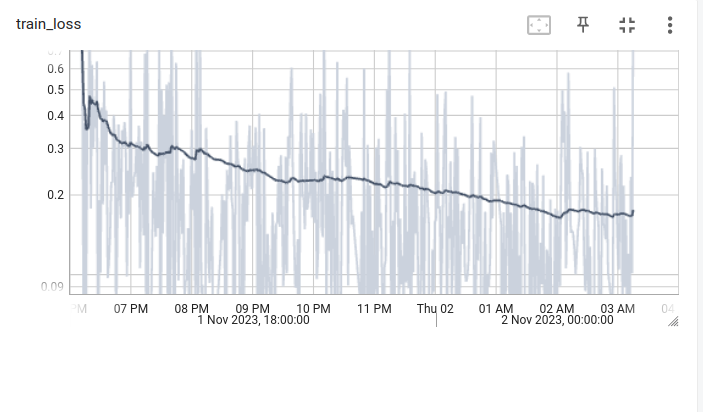

In [19]:
# Initializing best performing model -> replace with the path to best performing model
distilbert_path = URL + "destilbert_checkpoints/model-epoch=01-val_loss=0.2211.ckpt"
distilbert = CommentsModel.load_from_checkpoint(
    checkpoint_path = distilbert_path
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Estimating threshold best threshold based on the validation set

In [22]:
valid_dataset = ToxicDataset(df_valid)
valid_loader = DataLoader(
            valid_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS)

predictions, y_true, losses = model_preds(distilbert, valid_loader)

In [51]:
best_thresholds = threshold_estimation(predictions, y_true, target_list)
THRESHOLD = round(np.mean(best_thresholds), 2)

toxic: 0.9
severe_toxic: 0.9
obscene: 0.9
threat: 0.9
insult: 0.9
identity_hate: 0.9


## Evaluating model on the test set

In [23]:
# Getting predictions for test set
test_dataset = ToxicDataset(df_test)
test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS)

predictions, y_true, losses, input_ids = model_preds(distilbert, test_loader)

In [24]:
print(f"Average loss on the test set: {round(np.mean(losses), 3)}")

Average loss on the test set: 0.246


************************* ROC_AUC per label *************************
toxic: 0.98
severe_toxic: 0.99
obscene: 0.99
threat: 0.99
insult: 0.98
identity_hate: 0.99



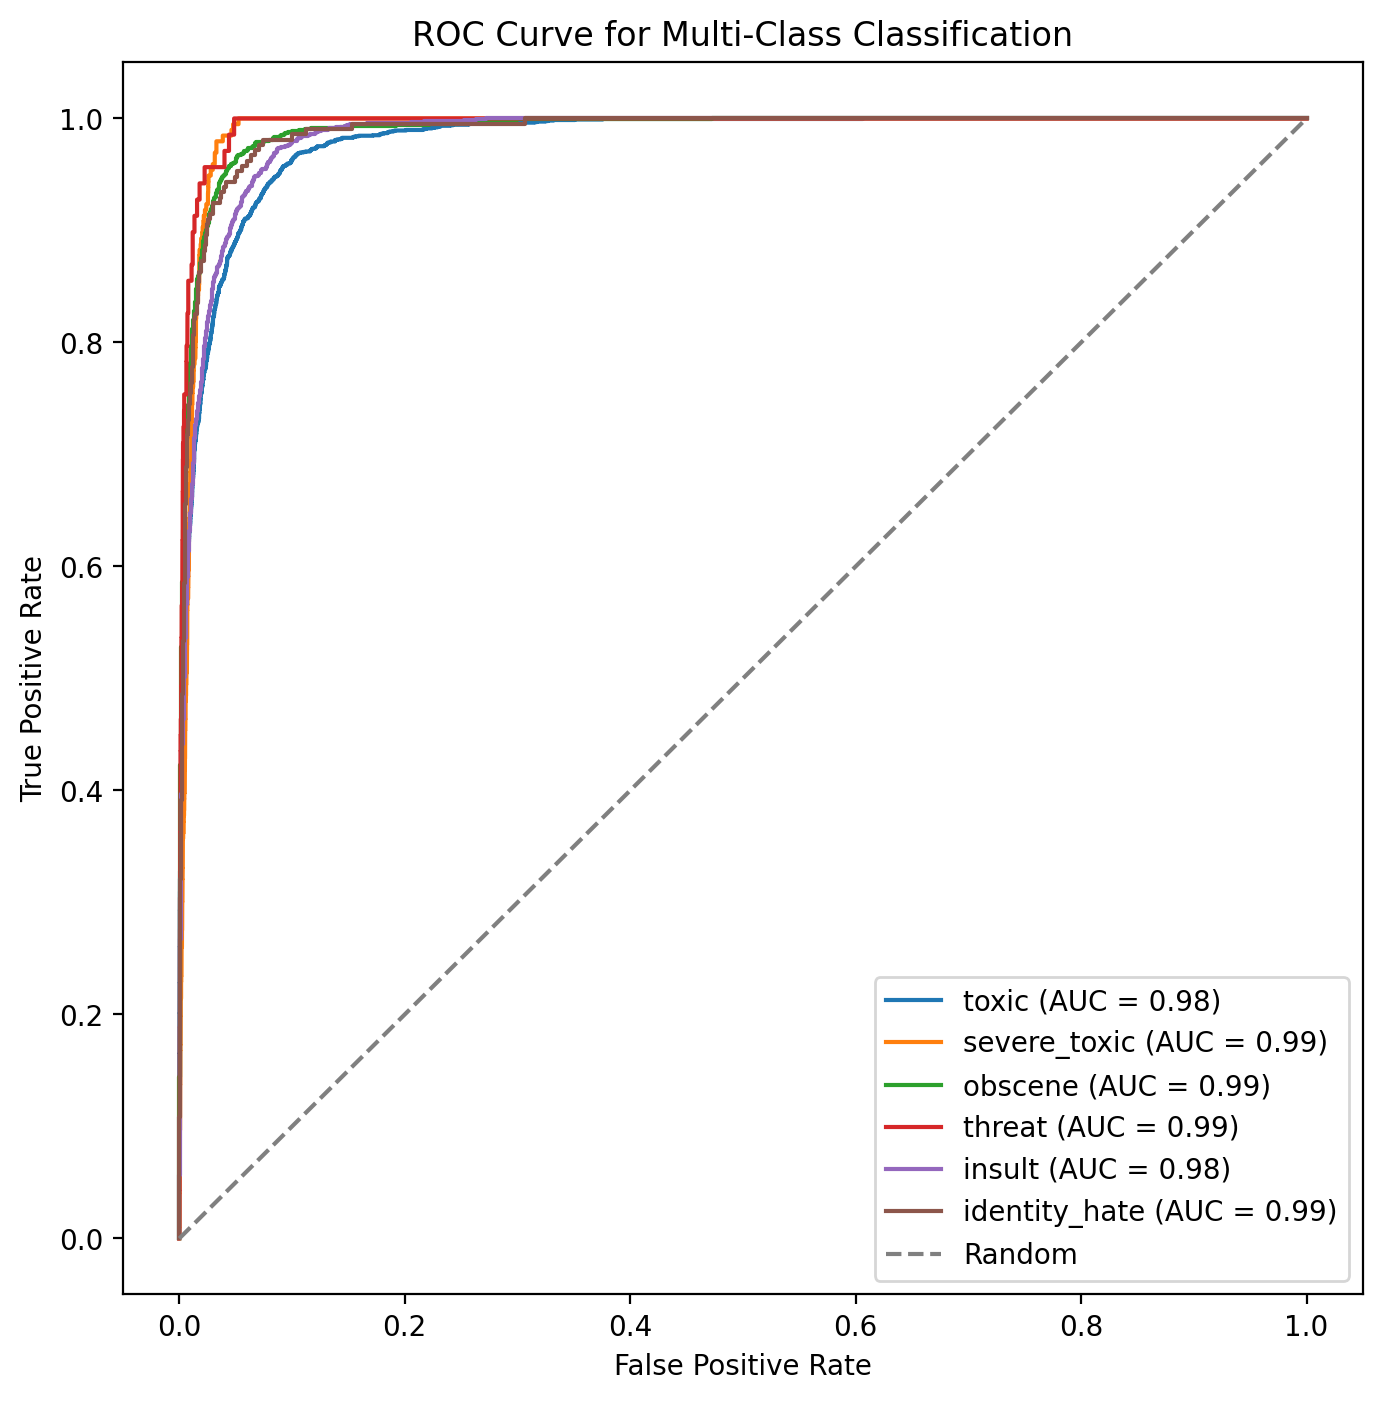


 ************************* Classification report *************************
               precision    recall  f1-score   support

        toxic       0.80      0.77      0.78      2138
 severe_toxic       0.24      0.95      0.38       196
      obscene       0.73      0.87      0.79      1214
       threat       0.16      0.91      0.27        69
       insult       0.64      0.81      0.71      1131
identity_hate       0.35      0.83      0.49       212

    micro avg       0.61      0.81      0.70      4960
    macro avg       0.49      0.86      0.57      4960
 weighted avg       0.69      0.81      0.73      4960
  samples avg       0.96      0.97      0.94      4960


 ************************* Normalized Confusion Matrices for Each Label *************************


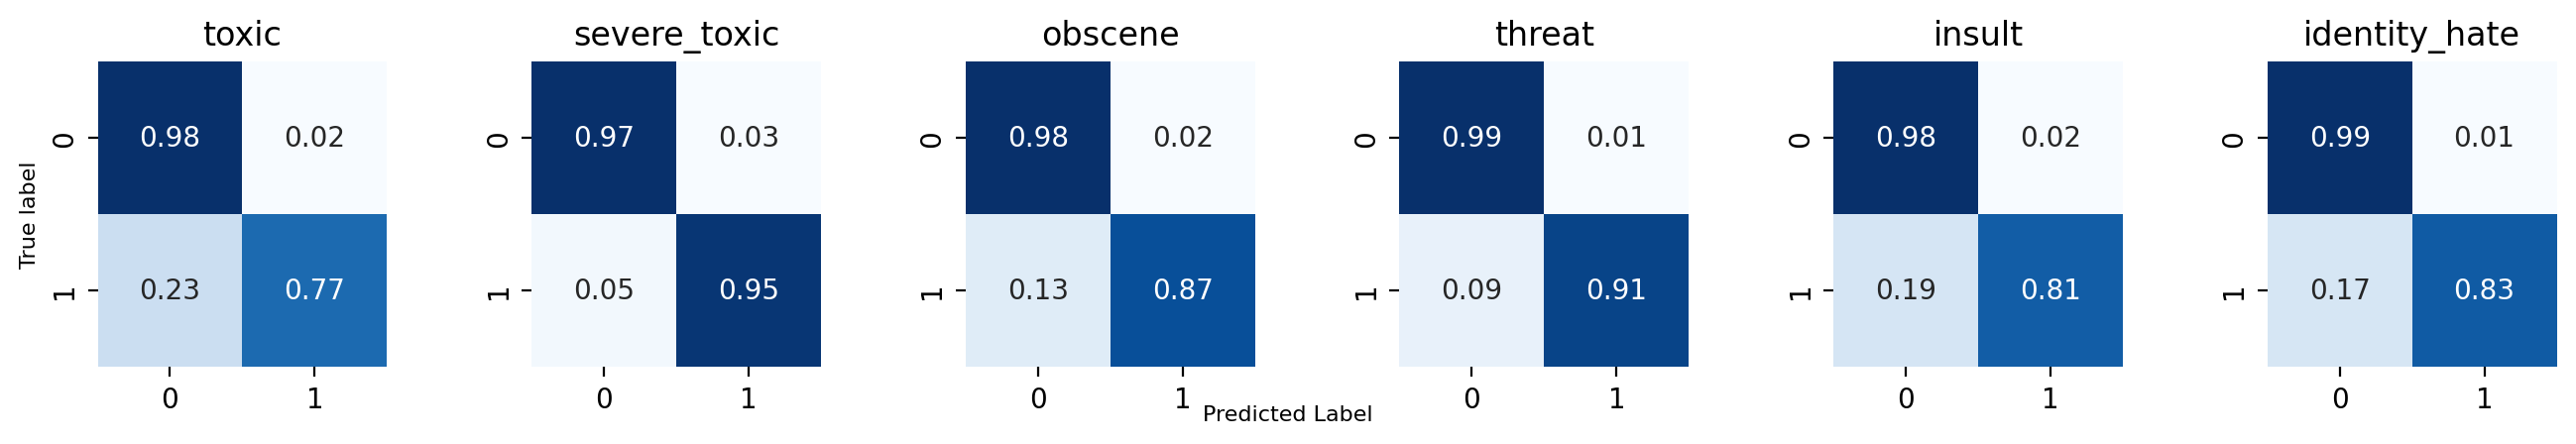

In [43]:
THRESHOLD = 0.9
metric_display(predictions, y_true, target_list, THRESHOLD)

* Our f1 score wighted metric is equal to 0.73
* The model had the highiest number of mistakes on toxic, insult and identity hate
* Sever toxic and threat waere the easiest to identify.

## Explaining examples with with the highiest mse

In [151]:
# Sanity check of the shapes of output
flattened_input_ids = list(chain(*input_ids))
len(flattened_input_ids), predictions.shape, y_true.shape

(22271, (22271, 6), (22271, 6))

Calculating mean squared errors for each comment and sorting them in ascending order.

In [152]:
mean_squared_errors = []
for y, y_hat, ids in zip(y_true, predictions, flattened_input_ids):
    mse = mean_squared_error(list(y), list(y_hat>THRESHOLD))
    mean_squared_errors.append(mse)

# Find indices of examples with highest MSE
indices_of_highest_mse = np.argsort(mean_squared_errors)[-2:].tolist()

# Initialization of tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

for i in indices_of_highest_mse:
    print(tokenizer.decode(flattened_input_ids[i], skip_special_tokens=True))
    print("predictions: ", (predictions[i, :]>THRESHOLD).astype(int))
    print("labels: ", y_true[i, :].astype(int))

edit request on january cheef keef is a bitch ass dude he is not about that life and hes a hoe ass dude he didnt kill little jojo cause he a scared ass hoe fuck you you claim you a g and a blood you stil a fucking hoe when my niggas catch you its sad cause you a bitch your mom going to get murderd and your daddy going to get raped
predictions:  [1 1 1 1 1 1]
labels:  [0 0 0 0 0 0]
ironically it's your own prophet that the jewish members of your organization should be offended by in his own words may god damn the goddamned jews! my god i think if i could get over there and had a gun i think i'd shoot'em myself! my god damn them in jesus'name! in jesus'name strike! strike! strike! god damn the jews! those antichrist christhating jews god damn them! o god if i had a gun i'd shoot them myself! god damn the jews! god damn them god damn them god damn them in jesus'name! damn the antichrist jews! damn them o god! god damn them! a prayer for the poor! hitler was either a scourge on the world's

The comments seems to be incorectly labeled. Let's go back to the dataframe.

In [156]:
df_test.loc[df_test["cleaned_comment"].str.lower().str.contains("cheef keef")]

,cleaned_comment,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
21488,Edit request on January Cheef keef is a bitch ass dude He is not about that life and hes a hoe ass dude He didnt kill little Jojo cause he a scared ass hoe fuck you you claim you a G and a blood You stil a fucking hoe When My Niggas catch you its sad cause you a bitch Your mom going to get murderd and your daddy going to get raped,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


It seems that some of the comments are incorrectly labeled which is why the model gives the highiest mse score for those lables.

## Training Roberta

In [38]:
# Initialization of the model and displaying architecture
model = CommentsModel(arch="roberta", to_train=PARAMS_TO_TRAIN_ROBERTA)
for child in model.children():
    print(child)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Initialization of logger, callbacks and training the model.

In [49]:
# logger = TensorBoardLogger(
#     URL, name="roberta"
# )

# checkpoint_callback = ModelCheckpoint(
#   dirpath= URL + "roberta_checkpoints",
#   filename="model-{epoch:02d}-{val_loss:.4f}",
#   save_top_k=2,
#   verbose=True,
#   monitor="val_loss",
#   mode="min"
# )
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)
# printing_callback = MyPrintingCallback()
# callbacks = [early_stopping_callback, checkpoint_callback, printing_callback]

# model = CommentsModel(arch="roberta", to_train=PARAMS_TO_TRAIN_ROBERTA)
# training(model, logger, callbacks)

The training of 2 epochs took 15 hours. On 3 epoch the runtime disconnected.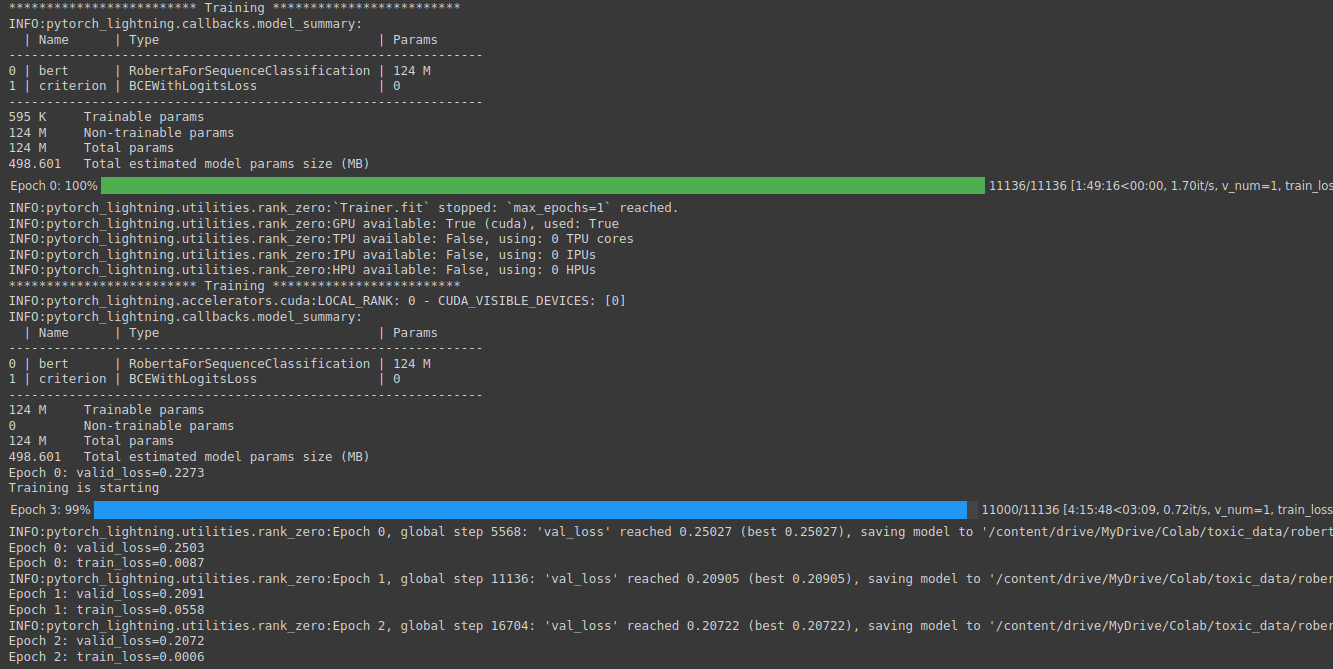


In [69]:
# %reload_ext tensorboard
# %tensorboard --logdir "/content/drive/MyDrive/Colab/toxic_data/roberta" --port=6006

The outcome from the above commands displayed the graph for training loss where we see instable loss in the first epoch and then more stable one. Because I was lacking one of the parameters in logging in validation loss I wasn't able to get the same graph. However form the above output we can see that the model started to overfit and the training would end up anyway with the early stopping.

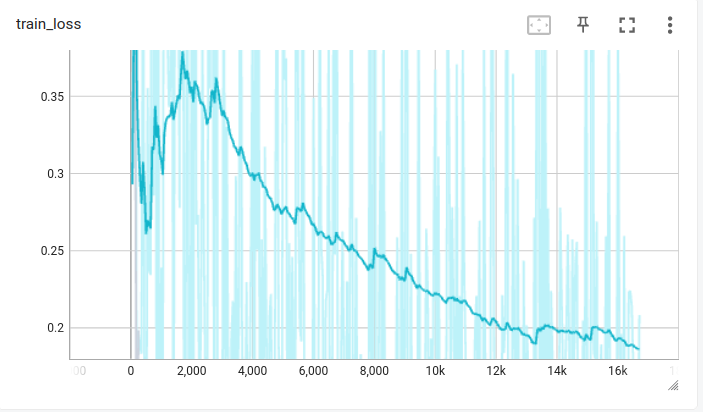

In [50]:
# Getting the best performing model -> replace with the path to best performing model
roberta_path = URL + "roberta_checkpoints/model-epoch=02-val_loss=0.2072.ckpt"
roberta = CommentsModel.load_from_checkpoint(
    checkpoint_path = roberta_path, arch="roberta", to_train=PARAMS_TO_TRAIN_ROBERTA)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Estimating best threshold based on the validation set

In [48]:
valid_dataset = ToxicDataset(df_valid, "roberta")
valid_loader = DataLoader(
            valid_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS)

predictions, y_true, losses, input_ids = model_preds(roberta, valid_loader)

In [169]:
best_thresholds = threshold_estimation(predictions, y_true, target_list)
THRESHOLD = round(np.mean(best_thresholds), 2)

toxic: 0.9
severe_toxic: 0.9
obscene: 0.9
threat: 0.9
insult: 0.9
identity_hate: 0.9


## Evaluating model on the test set

In [51]:
# Getting predictions for test set
THRESHOLD = 0.9
test_dataset = ToxicDataset(df_test, "roberta")
test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS)

predictions, y_true, losses, input_ids = model_preds(roberta, test_loader)

In [52]:
print(f"Average loss on the test set: {round(np.mean(losses), 3)}")

Average loss on the test set: 0.232


************************* ROC_AUC per label *************************
toxic: 0.98
severe_toxic: 0.99
obscene: 0.99
threat: 1.0
insult: 0.99
identity_hate: 0.99



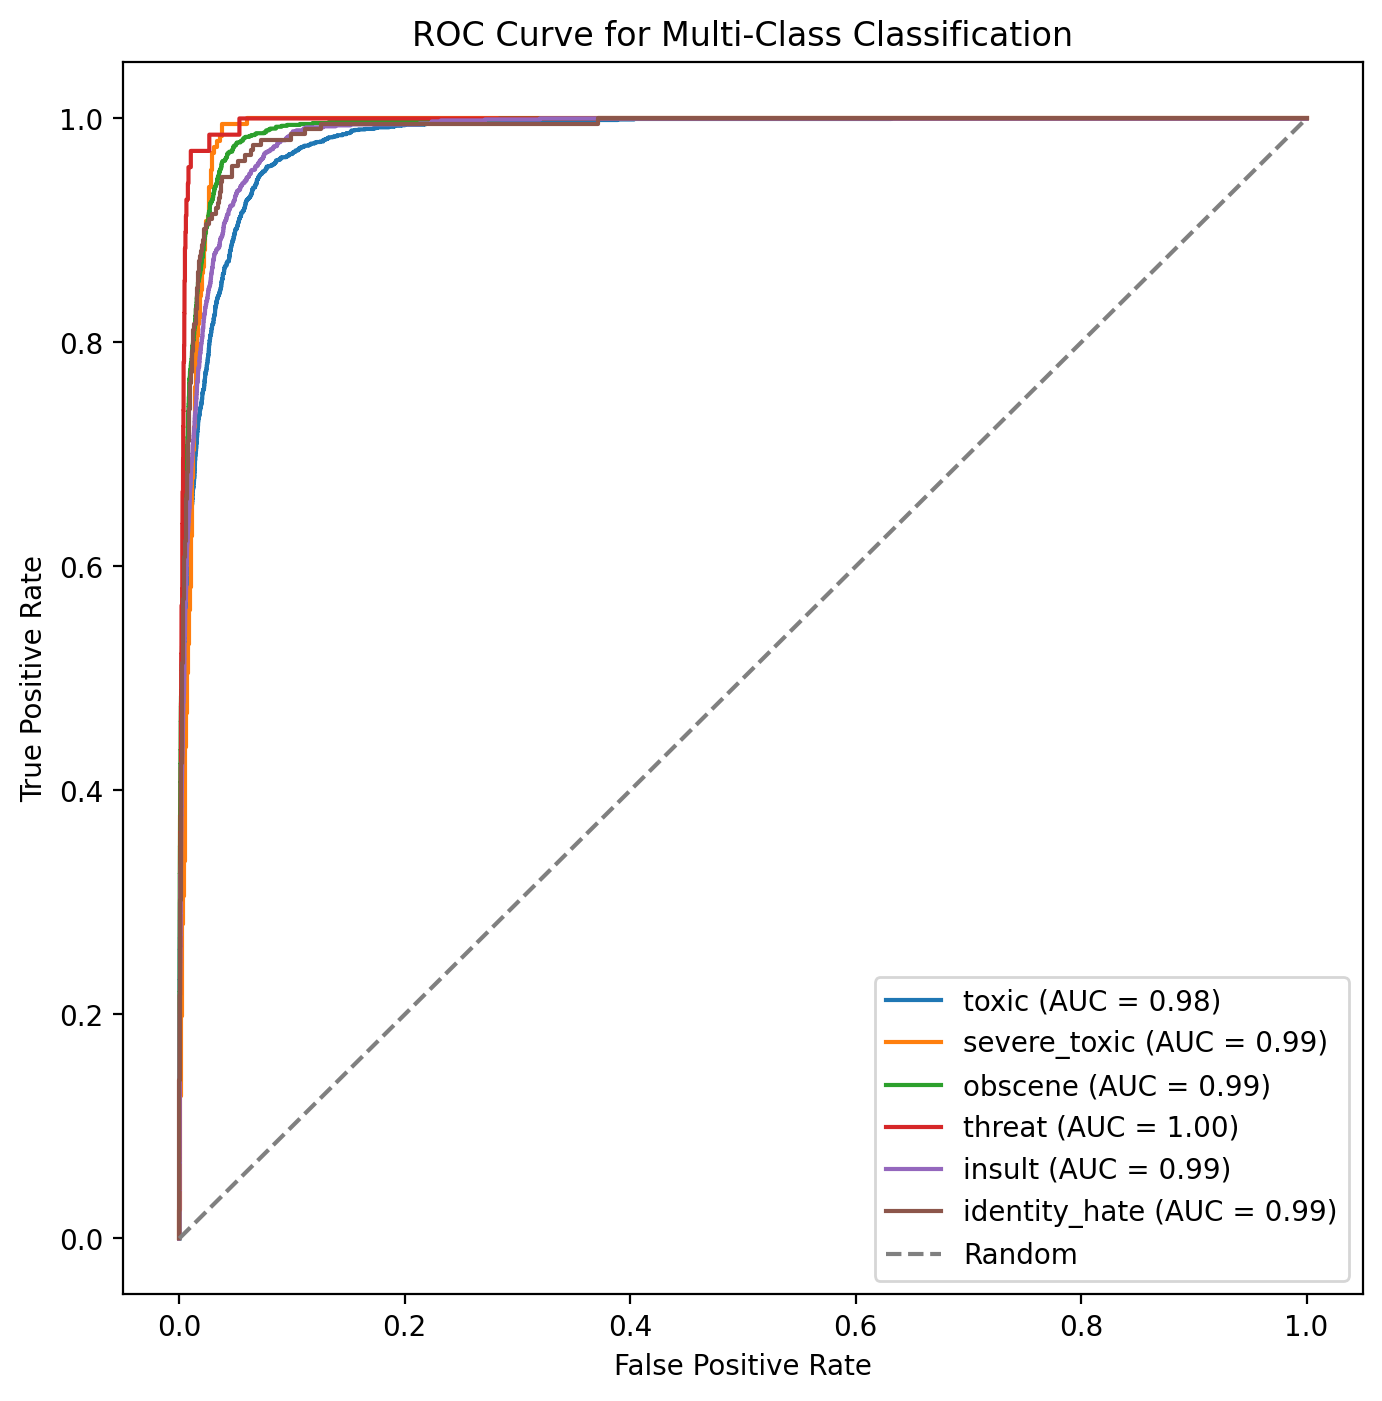


 ************************* Classification report *************************
               precision    recall  f1-score   support

        toxic       0.75      0.81      0.78      2138
 severe_toxic       0.22      0.97      0.35       196
      obscene       0.68      0.90      0.78      1214
       threat       0.21      0.97      0.35        69
       insult       0.59      0.88      0.71      1131
identity_hate       0.30      0.89      0.44       212

    micro avg       0.58      0.86      0.69      4960
    macro avg       0.46      0.90      0.57      4960
 weighted avg       0.65      0.86      0.73      4960
  samples avg       0.95      0.98      0.93      4960


 ************************* Normalized Confusion Matrices for Each Label *************************


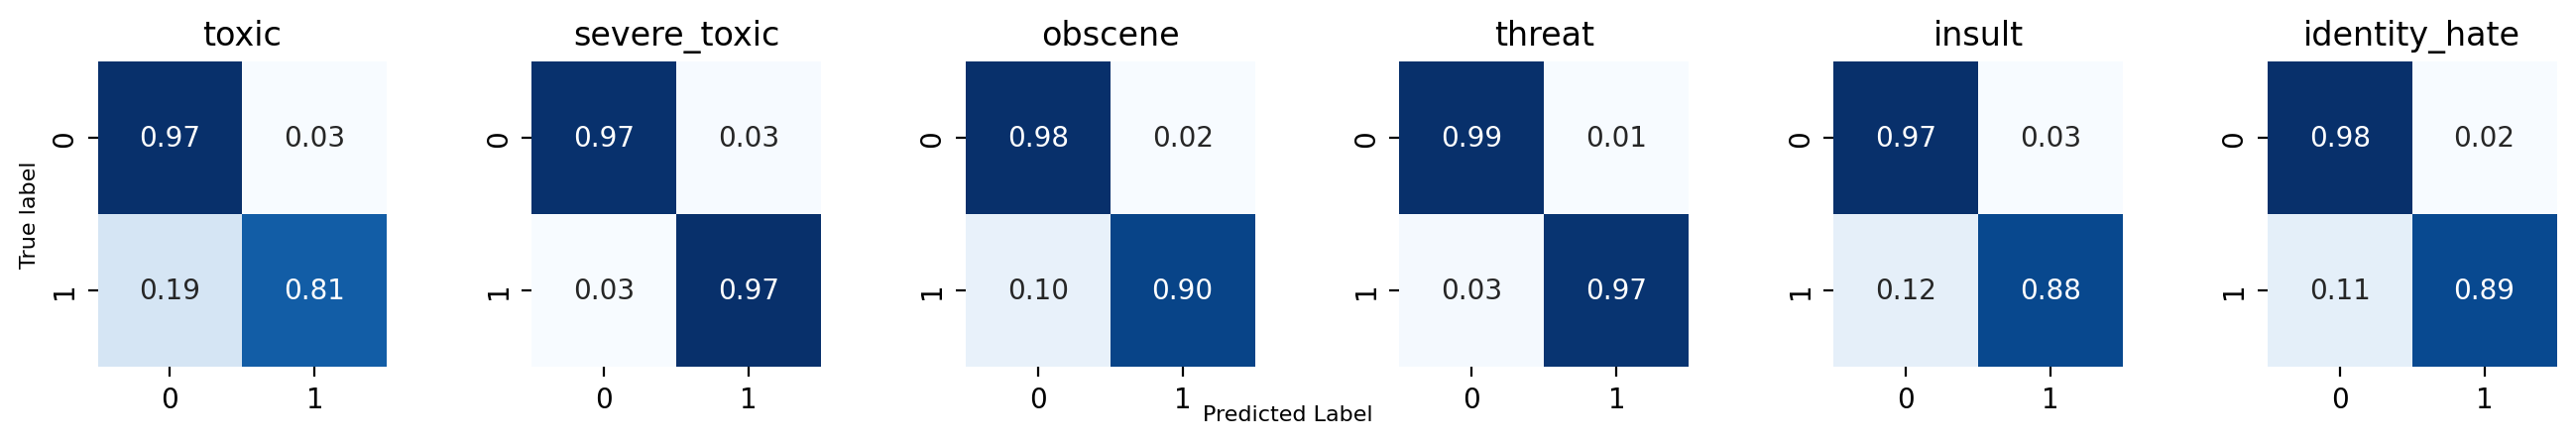

In [53]:
metric_display(predictions, y_true, target_list, THRESHOLD)

* The weighted f1 score 0.73
* The hardest to predict were toxic and insult comments
* The easiest to predict were severe_toxic and insult

## Steps to take for predicting new comment

* clean the string with cleaned_string(text) function
* initialize dataloader
* make prediction


In [69]:
# Example comment
comment = "It's not fun to wait for the response."
df_new = pd.DataFrame({'cleaned_comment': [cleaned_string(comment)]})
new_dataset = ToxicDataset(df_new, "roberta", target_list=None)
new_loader = DataLoader(
            new_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS)

device = "cuda" if torch.cuda.is_available() else "cpu"
roberta.eval().to(device)
predictions = []
with torch.no_grad():
    for i, batch in enumerate(new_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs, loss = roberta(**batch)
        batch_predictions = outputs.tolist()
        predictions += batch_predictions

{name: round(pred, 4) for name, pred in zip(target_list, predictions[0])}

{'toxic': 0.0048,
 'severe_toxic': 0.0,
 'obscene': 0.0005,
 'threat': 0.0001,
 'insult': 0.0006,
 'identity_hate': 0.0001}

## Conclusions

* Some of the comments are wrongly labeled.
* The architectures proposed by the Hugging Face team turned out to be very effective although time consuming.
* Roberta trained for much longer but had comparable metrics of importance.

## Imporvements

* Trying different architectures of the last layers
* Trying to speed up the proces with minimizing max length of sequence (128 should be sufficient for the distribution of number of words in comments)
* Trying different approaches for cleaning ex. removing stopwords
* Including cleaned_string function in dataset class
* Build a pipeline for predictions
* Adding function for making predictions to the module
* Adding parameter to log val_loss to tensorboard logger


Source of the split function
https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat

## Appendix

The following code is an example of simpler achitecture with less parameters to train and reassigned number of sequence. I've done fast developement check for potential bugs. The model could be then trained and evaluated. This could be actually the first trained model which converts faster.

In [65]:
MAX_SEQUENCE_LENGTH = 128
class SimpleModel(pl.LightningModule):
    """
    Basic PyTorch Lightning module for toxic comment classification
    based on DistilBertModel.

    Parameters:
        num_classes (int): number of classes for sequence classification
        lr (float): learning rate for optimizer

    Returns:
        torch.Tensor: probability outputs between 0 and 1
        torch.Tensor: loss
    """
    def __init__(self, n_classes: int=6, learning_rate: float=1e-3):
        super().__init__()
        self.lr = learning_rate
        self.n_classes = n_classes
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(768, n_classes)
        self.base_grad(requires_grad = False)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHTS)

    def base_grad(self, requires_grad: bool):
       for param in self.bert.parameters():
            param.requires_grad = requires_grad

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]
        pooler = hidden_state[:, 0]
        pooler = self.classifier(pooler)
        output = torch.sigmoid(pooler)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def configure_optimizers(self):

        return optim.AdamW([p for p in self.parameters() if p.requires_grad],
                           lr=self.lr, eps=1e-08)

    def train_dataloader(self):

        dataset = ToxicDataset(df_train)
        loader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS
        )
        return loader

    def val_dataloader(self):

        dataset = ToxicDataset(df_valid)
        loader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS
        )
        return loader

    def training_step(self, batch, batch_idx):

        loss, ouput = self.forward(**batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):

        loss, output = self.forward(**batch)
        self.log("val_loss", loss, prog_bar=True)
        return loss

In [66]:
bert = SimpleModel()
trainer = pl.Trainer(fast_dev_run=True)
trainer.fit(bert)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | DistilBertModel   | 66.4 M
1 | classifier | Linear            | 4.6 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
4.6 K     Trainable params
66.4 M    Non-trainable params
66.4 M    Total params
265.470   Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
